Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle

First reload the data we generated in _notmist.ipynb_.

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 2 to [0.0, 1.0, 0.0 ...], 3 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [4]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

In [11]:
train_subset = 1000
beta = 0.01

graph = tf.Graph()

with graph.as_default():
    
    tf_train_dataset = tf.constant(
        train_dataset[:train_subset, :]
    )
    tf_train_labels = tf.constant(
        train_labels[:train_subset]
    )
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_datast = tf.constant(test_dataset)
    
    ''' variables '''
    weights = tf.Variable(
        tf.truncated_normal([
            image_size * image_size,
            num_labels
        ])
    )
    biases = tf.Variable(tf.zeros([num_labels]))
    
    ''' training computation function '''
    
    logits = tf.matmul(tf_train_dataset, weights) + biases
    
    ''' loss function using L2 Regularization '''
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)
    )
    loss_l2 = tf.reduce_mean(
        loss + beta * tf.nn.l2_loss(weights)
    )
    
    ''' optimize '''
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss_l2)
    
    ''' predictions '''
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(
        tf.matmul(tf_valid_dataset, weights) + biases
    )
    test_prediction = tf.nn.softmax(
        tf.matmul(tf_test_datast, weights) + biases
    )

Initialized
Loss at step 0: 18.298470
Training accuracy: 9.4%
Validation accuracy: 10.4%

Loss at step 100: 0.866407
Training accuracy: 82.2%
Validation accuracy: 68.1%

Loss at step 200: 0.414028
Training accuracy: 91.5%
Validation accuracy: 72.4%

Loss at step 300: 0.310625
Training accuracy: 94.7%
Validation accuracy: 76.0%

Loss at step 400: 0.286541
Training accuracy: 95.2%
Validation accuracy: 77.6%

Loss at step 500: 0.280893
Training accuracy: 95.4%
Validation accuracy: 78.4%

Loss at step 600: 0.279271
Training accuracy: 95.5%
Validation accuracy: 78.5%

Loss at step 700: 0.278583
Training accuracy: 95.3%
Validation accuracy: 78.5%

Loss at step 800: 0.278185
Training accuracy: 95.4%
Validation accuracy: 78.6%

Loss at step 900: 0.277924
Training accuracy: 95.4%
Validation accuracy: 78.6%

Loss at step 1000: 0.277746
Training accuracy: 95.4%
Validation accuracy: 78.6%

Test accuracy: 86.0%


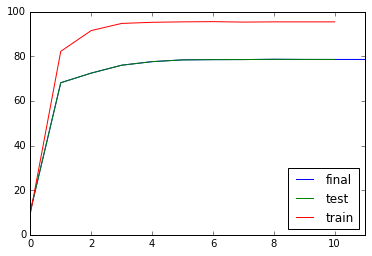

In [18]:
%matplotlib inline
import pandas as pd

def getTFResults(graph, num_iterations):

    def accuracy(predictions, labels):
        return (
            100.0 * np.sum(
                np.argmax(predictions, 1) == np.argmax(labels, 1)
            ) / predictions.shape[0]
        )

    df_accuracy = []

    with tf.Session(graph=graph) as session:
        tf.initialize_all_variables().run()

        print('Initialized')

        for step in range(num_iterations):
            _, l, predictions = session.run([optimizer, loss, train_prediction])

            if (step % 100 == 0):
                print('Loss at step %d: %f' % (step, l))
                print(
                    'Training accuracy: %.1f%%' % accuracy(
                        predictions,
                        train_labels[:train_subset, :]
                    )
                )
                print(
                    'Validation accuracy: %.1f%%' % accuracy(
                        valid_prediction.eval(),
                        valid_labels
                    )
                )
                print('')

                df_accuracy.append({
                    'step': step,
                    'train': accuracy(
                        predictions,
                        train_labels[:train_subset, :]
                    ),
                    'test': accuracy(
                        valid_prediction.eval(),
                        valid_labels
                    ),
                    'final': accuracy(
                        valid_prediction.eval(),
                        valid_labels
                    )
                })
        print(
            'Test accuracy: %.1f%%' % accuracy(
                test_prediction.eval(),
                test_labels
            )
        )

        df_accuracy.append({
            'step': step,
            'final': accuracy(
                valid_prediction.eval(),
                valid_labels
            )
        })
    df_accuracy = pd.DataFrame(df_accuracy)

    df_accuracy[['final', 'test', 'train']].plot()

getTFResults(graph, 1001)

---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

Initialized
Loss at step 0: 19.320166
Training accuracy: 0.0%
Validation accuracy: 5.2%

Loss at step 100: 0.035619
Training accuracy: 100.0%
Validation accuracy: 47.0%

Loss at step 200: 0.035016
Training accuracy: 100.0%
Validation accuracy: 53.2%

Loss at step 300: 0.038982
Training accuracy: 100.0%
Validation accuracy: 58.9%

Loss at step 400: 0.041634
Training accuracy: 100.0%
Validation accuracy: 62.6%

Loss at step 500: 0.042686
Training accuracy: 100.0%
Validation accuracy: 64.2%

Loss at step 600: 0.042973
Training accuracy: 100.0%
Validation accuracy: 64.9%

Loss at step 700: 0.043022
Training accuracy: 100.0%
Validation accuracy: 65.0%

Loss at step 800: 0.043012
Training accuracy: 100.0%
Validation accuracy: 65.2%

Loss at step 900: 0.042989
Training accuracy: 100.0%
Validation accuracy: 65.1%

Loss at step 1000: 0.042965
Training accuracy: 100.0%
Validation accuracy: 65.1%

Test accuracy: 71.6%


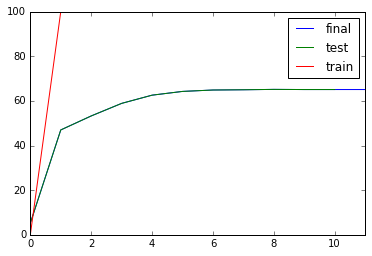

In [21]:
train_subset = 100
beta = 0.01

graph = tf.Graph()

with graph.as_default():
    
    tf_train_dataset = tf.constant(
        train_dataset[:train_subset, :]
    )
    tf_train_labels = tf.constant(
        train_labels[:train_subset]
    )
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_datast = tf.constant(test_dataset)
    
    ''' variables '''
    weights = tf.Variable(
        tf.truncated_normal([
            image_size * image_size,
            num_labels
        ])
    )
    biases = tf.Variable(tf.zeros([num_labels]))
    
    ''' training computation function '''
    
    logits = tf.matmul(tf_train_dataset, weights) + biases
    
    ''' loss function using L2 Regularization '''
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)
    )
    loss_l2 = tf.reduce_mean(
        loss + beta * tf.nn.l2_loss(weights)
    )
    
    ''' optimize '''
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss_l2)
    
    ''' predictions '''
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(
        tf.matmul(tf_valid_dataset, weights) + biases
    )
    test_prediction = tf.nn.softmax(
        tf.matmul(tf_test_datast, weights) + biases
    )
    
getTFResults(graph, 1001)

---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

In [45]:
batch_size = 128
beta = 0.001

graph = tf.Graph()
with graph.as_default():

    tf_train_dataset = tf.placeholder(
        tf.float32,
        shape=(batch_size, image_size * image_size)
    )
    tf_train_labels = tf.placeholder(
        tf.float32,
        shape=(batch_size, num_labels)
    )
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_datast = tf.constant(test_dataset)
    
    ''' hidden layer '''
    num_nodes_hidden = 1024
    weights_hidden = tf.Variable(
        tf.truncated_normal([
            image_size * image_size,
            num_nodes_hidden
        ])
    )
    biases_hidden = tf.Variable(
        tf.zeros([num_nodes_hidden])
    )
    layer_hidden = tf.nn.relu(
        tf.matmul(
            tf_train_dataset,
            weights_hidden
        ) + biases_hidden
    )
    
    ''' dropout hidden layer '''
    prob_to_keep = tf.placeholder('float')
    layer_drop_hidden = tf.nn.dropout(
        layer_hidden,
        prob_to_keep
    )
    
    ''' variables '''
    weights = tf.Variable(
        tf.truncated_normal([
            num_nodes_hidden,
            num_labels
        ])
    )
    biases = tf.Variable(tf.zeros([num_labels]))
    
    ''' training computation function '''
    logits = tf.matmul(layer_drop_hidden, weights) + biases
    
    ''' loss function using L2 Regularization '''
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)
    )
    loss_l2 = tf.reduce_mean(
        loss + beta * tf.nn.l2_loss(weights)
    )
    
    ''' optimize '''
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss_l2)
    
    ''' predictions '''
    train_prediction = tf.nn.softmax(logits)
    valid_relu = tf.nn.relu(
        tf.matmul(
            tf_valid_dataset,
            weights_hidden
        ) + biases_hidden
    )
    valid_prediction = tf.nn.softmax(
        tf.matmul(
            valid_relu,
            weights
        ) + biases
    )
    
    test_relu = tf.nn.relu(
        tf.matmul(
            tf_test_datast,
            weights_hidden
        ) + biases_hidden
    )
    test_prediction = tf.nn.softmax(
        tf.matmul(
            test_relu,
            weights
        ) + biases
    )

Initialized
Minibatch loss at step 0: 444.892700
Minibatch accuracy: 11.7%
Validation accuracy: 27.1%

Minibatch loss at step 500: 39.635483
Minibatch accuracy: 72.7%
Validation accuracy: 79.4%

Minibatch loss at step 1000: 21.397570
Minibatch accuracy: 68.0%
Validation accuracy: 80.2%

Minibatch loss at step 1500: 15.176024
Minibatch accuracy: 76.6%
Validation accuracy: 80.0%

Minibatch loss at step 2000: 5.474715
Minibatch accuracy: 79.7%
Validation accuracy: 80.3%

Minibatch loss at step 2500: 5.220998
Minibatch accuracy: 73.4%
Validation accuracy: 79.4%

Minibatch loss at step 3000: 3.745796
Minibatch accuracy: 77.3%
Validation accuracy: 80.4%

Minibatch loss at step 3500: 6.166140
Minibatch accuracy: 74.2%
Validation accuracy: 80.0%

Minibatch loss at step 4000: 7.712373
Minibatch accuracy: 75.8%
Validation accuracy: 80.4%

Minibatch loss at step 4500: 3.492334
Minibatch accuracy: 75.0%
Validation accuracy: 79.0%

Minibatch loss at step 5000: 6.194180
Minibatch accuracy: 81.2%
Val

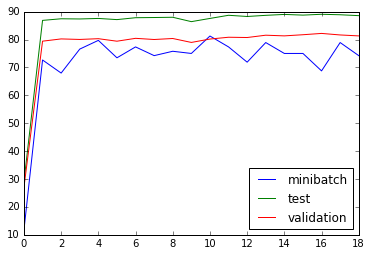

In [50]:
num_steps = 9001

results = []
with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]

        feed_dict = {
            tf_train_dataset : batch_data,
            tf_train_labels : batch_labels,
            prob_to_keep : 0.5
        }
        _, l, predictions = session.run( [optimizer, loss_l2, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy( valid_prediction.eval(), valid_labels) )
            print('')
            
            results.append({
#                 'loss': l,
                'minibatch': accuracy(predictions, batch_labels),
                'validation': accuracy( valid_prediction.eval(), valid_labels),
                'test': accuracy(test_prediction.eval(), test_labels)
            })
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

results = pd.DataFrame(results)
results.plot()

---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---
